# Poisson likelihood calculator

Given $M$ components, each with an estimated rate $\vec{\beta}$ determined by a normal distribution with uncertainty $\vec{\sigma}$, calculate the confidence itervals and perform a hypothesis tests for each parameter $b$.

Nominally each event corresponds to a set of observables $\vec{x}$ of $N$ measurements, for any given measurement, the probability for that particular measurement to come from a particular components is given by

$$ P_i(\vec{x}) \tag{1}$$

The prior probability is then formed through a combination of these components such that the total probability is 

$$ \mathbf{P} = \sum_i^M P_i(\vec{x}) \tag{2}$$

The likelihood for a full data set of $N$ measurements is the product of each event total probability

$$
\mathcal{L}(\vec{x}) = 
\prod_j^N \left( \sum_i^M b_iP_i(\vec{x}) \right) / \sum_i^Mb_i 
\tag{3}
$$

We can extend the likelihood by proclaiming that each components as well as the sum of components are simply a stochastic process, produces the extended likelihood:

$$
\mathcal{L}(\vec{x}) = 
\frac{\text{e}^{-\sum_i^Mb_i}}{N!} \prod_j^N \left( \sum_i^M b_iP_i(\vec{x}) \right) 
\tag{4}
$$

Finally, we can claim that we have _a priori_ knowledge of the parameters, whether it be through side-band analysis or external constraints, by including those constraints via some prior probability. Given no specific knowledge of the shape of that prior, we will consider the information we receive on the variables to be normally distributed and multiply the likelihood by those constraints

$$
\mathcal{L}(\vec{x}) = 
\frac{\text{e}^{-\sum_i^Mb_i}}{N!} 
\prod_j^N \left( \sum_i^M b_iP_i(\vec{x}) \right) 
\frac{1}{\sqrt{2\pi \sigma_i^2}}
\text{exp}\left({\frac{-(\beta_i-b_i)^2}{2\sigma_i^2}}\right)
\tag{5}
$$

A few definitions to simplify things:
$$ \lambda := \sum_i^Mb_i \tag{6}$$

Then then our objective function $\mathcal{O} = -\text{Ln}\mathcal{L}$

$$
\mathcal{O} = \lambda + \text{Ln}N! 
-\sum_j^N\text{Ln}\left( \sum_i^M b_iP_i(\vec{x}) \right) 
+ \sum_i^M \left( \frac{(\beta_i-b_i)^2}{2\sigma_i^2} 
    + \text{Ln}\sqrt{2\pi \sigma_i} \right)
\tag{7}
$$

Finally, for a counting analysis we assume that an optimal set of cuts has been applied which optimizes the sensitivity to a particular parameter, which simplifies the likelihood such that

$$ P_i(\vec{x}) := 1 \tag{8}$$

Also, because the shape of the likelihood space is independent of constant parameters, we can drop the $\text{Ln}\sqrt{2\pi \sigma_i}$ terms. We could also remove the $\text{Ln}N!$ term as well, but for numerical stability we will keep it around, but use Sterling's approximation: $\text{Ln}N! \approx N\text{Ln}N - N$. The remaining objective function we will thus use is:

$$
\mathcal{O} = \lambda - N\text{Ln}\lambda + N\text{Ln}N - N 
    + \sum_i^M \left( \frac{(\beta_i-b_i)^2}{2\sigma_i^2} \right)
\tag{9}
$$

_Note: If the different values of $\beta$ differ by orders of magnitude, it might be worth forming an affine invariant form of the likelihood, otherwise the $\text{Ln}\sqrt{2\pi \sigma_i}$ term should not matter_

[Profile Likelihood](https://www.stat.tamu.edu/~suhasini/teaching613/chapter3.pdf)

In [1]:
include("./src/WatchFishBackup.jl")
using .WatchFish

### Model Building
Three structures are used to build, test, and fit models. These are the `Model`, `Component`, and `Result`--all of which are mutable.

We begin by initializing a default `Model` and one-by-one use `add_component!` to modify the `Model`.

The intention is to provide multiple ways to evaluate the uncertainties, the default here is to compute the profile likelihood.

In [3]:
# In the fish model we take the generic likelihood and enforce poisson statistics, thereby
# eliminating correlations between parameters.

m = Model()

add_component!(m, "Signal", 20.0; σ=Inf)
add_component!(m, "Bkg 1",  30.0; σ=0.1)
add_component!(m, "Bkg 2",  40.0; σ=45.0)
add_component!(m, "Bkg 3",  12.0; σ=12.0)

data = 100 #events
results = run_fish!(m, data)

println("Found min, profiling now")

# Results stored in a DataFrame.jl
compute_profiled_uncertainties!(results; σ=1)
pr = pretty_results(results)

Found min, profiling now


,Name,Estimate,Constraint,Fit,Interval_Low,Interval_High
,String,Float64,Float64,Float64,Float64,Float64
1,Signal,20.0,Inf,18.0,-23.0,59.0
2,Bkg 1,30.0,0.1,30.0,30.0,30.0
3,Bkg 2,40.0,45.0,40.0,1.0,67.0
4,Bkg 3,12.0,12.0,12.0,1.0,23.0


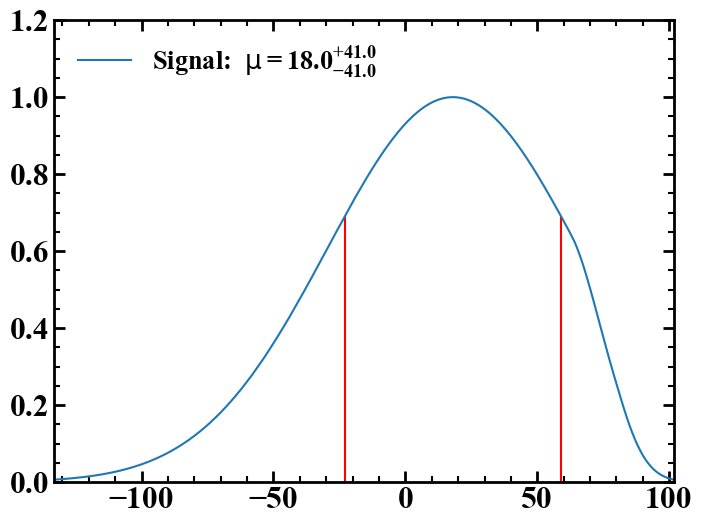

(y[x .>= low])[1] = 0.690273032548681


findfont: Font family ['Nimbus Roman Italic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans.


In [4]:
using PyPlot
plt.style.use("watchman")

hs = x -> x >= 0 ? 1 : 0
profile!("Signal", results; prior=nothing)
uncertainty!("Signal", results )

interval_plot(results, "Signal")
plt.savefig("profile.svg")
plt.show()

## Or with prior

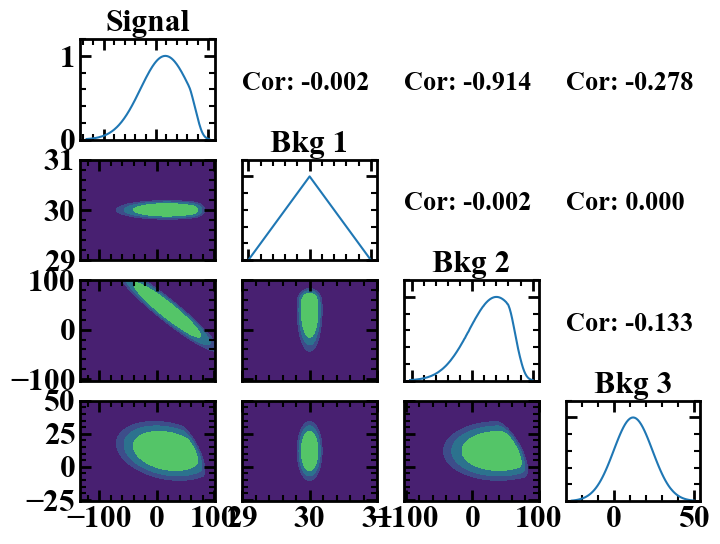

In [5]:
using PyPlot

correlation_plots(results)

plt.show()

In [ ]:
# Correlation Matrix -- Derive from correlation_plots, store in results

In [6]:
# Generate fake experiments; two set => Positive, Negative

## Is this the correct way to express everything. One model per time t (say day)

days = collect(1:5:1000) # 1 to 100 days
days = exp10.(range(0,stop=4,length=100))
hs = x -> x >= 0 ? 1 : 0

results_set = []
for d in days
    m = Model()
    
    add_component!(m, "Signal", 2.0 * d; σ=Inf)
    add_component!(m, "Bkg 1",  3.0 * d; σ=0.2*d )
    #add_component!(m, "Bkg 1",  3.0 * d; σ=0.1*(3.0*d))
    #add_component!(m, "Bkg 2",  4.0 * d; σ=0.1*(4.0*d))
    #add_component!(m, "Bkg 3",  1.0 * d; σ=0.1*(1.0*d))
    
    #data = random_dataset(m)
    data = 4.0 * d
    results = run_fish!(m, data)
    profile!("Signal", results; prior=hs, step=0.1, stop=20)
    uncertainty!("Signal", results, σ=1)
    push!(results_set, results)
end

# Results stored in a DataFrame.jl
#compute_profiled_uncertainties!(results; σ=1)
#pretty_results(results)

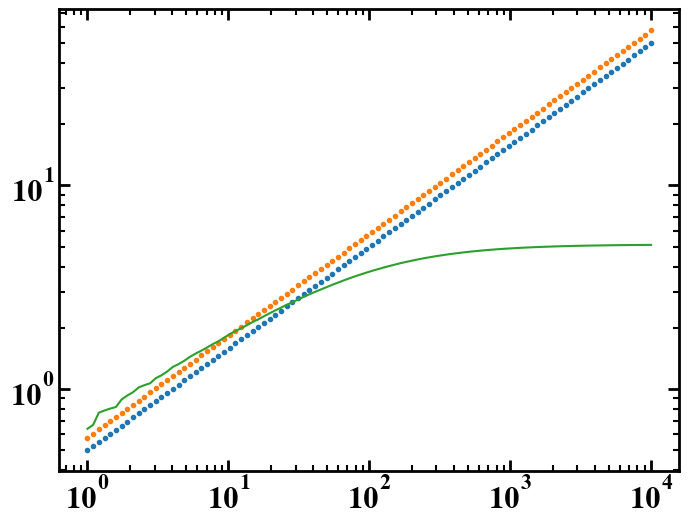

sensitivity("Signal", results_set[20]) = 0.8650008489694598


In [7]:
using SpecialFunctions
sens = []

function sensitivity(name, results;
    mode="FC", prior=nothing)
    # in sigma or cl?
    comp = results.model.component_dict[name]
    x, y = comp.likelihood_x, comp.likelihood_y
    if prior != nothing
        y = y .* prior.(x)
    end
    xselect = (x .>= 0)
    x = x[xselect]
    y = y[xselect]
    y = y / sum(y)
    cumulative = cumsum(y)
    if mode == "FC"
        cy = sortperm(y; rev=true)
        cum_y = cumsum(y[cy])
        cum_x = x[cy]
        # Need to find where it first crosses zero
        first_min = cum_y[ cum_x .== x[1] ]
    end
    return minimum([first_min[1], 1])
end

@show sensitivity("Signal", results_set[20])

for rs in results_set
    push!(sens, erfinv( sensitivity("Signal", rs))*2^0.5 )
end


plt.plot(days, 1/sqrt(4)*sqrt.(days),".")
plt.plot(days, 1/sqrt(3)*sqrt.(days),".")
plt.plot(days, sens)
plt.yscale("log")
plt.xscale("log")
plt.show()
#interval_plot(results_set[20], "Signal")
#@show days[ lb .>= 0 ][1]
#plot(days, lb)

In [ ]:
# Cowen Plot

In [ ]:
# ROC curve

In [ ]:
# Confusion Matrix

In [ ]:
# Documentation

In [ ]:
# Refactor code into sub-files, project.toml, mybinder, etc ...

In [ ]:
# Time dependent systematic (maybe)